working on a figure to show our answer to the question: "why measure kinetics?"

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [21]:
def f_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(-kappa * (1 - np.exp(-kdeg * x))) + fmod_0

In [45]:
db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
global_refit_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/02_representative_timecourses/global_refit_results.db'


# Connect to new.db
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Attach the global_refit DB
cursor.execute("""
    ATTACH DATABASE ? AS global
""", (global_refit_path,))

# Execute the join with base from nucleotides table
cursor.execute("""
    SELECT 
        gf.site,
        gf.log_kappa,
        gf.log_kdeg,
        gf.log_fmod_0,
        pr.id AS rxn_id,
        gf.r2,
        c.disp_name AS construct_name,
        nt.base
    FROM global.global_fits gf
    JOIN reaction_groups rg ON rg.id = gf.rg_id
    JOIN probing_reactions pr ON pr.rg_id = rg.id
    JOIN constructs c ON c.id = pr.construct_id
    JOIN nucleotides nt ON nt.construct_id = pr.construct_id AND nt.site = gf.site
    WHERE pr.id = (
        SELECT MIN(pr2.id)
        FROM probing_reactions pr2
        WHERE pr2.rg_id = rg.id
    )
               AND c.disp_name = '4U_wt' AND nt.site IN (29, 18) AND pr.temperature = 37
""")

results = cursor.fetchall()

# Convert results to DataFrame
df = pd.DataFrame(results, columns=['site', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'rxn_id', 'r2', 'construct_name', 'base'])
df = df.drop_duplicates()
df_grouped = df.groupby('site').mean(numeric_only=True)
df_grouped

,log_kappa,log_kdeg,log_fmod_0,rxn_id,r2
site,,,,,
18,-3.016878,-6.72628,-6.638655,427.4,0.991875
29,-3.556199,-6.72628,-7.091626,427.4,0.995442


$$
r = 1 - \exp(-\kappa \cdot (1 - \exp(-k_{\text{deg}}\cdot t)))\\
-\ln(1-r) = \kappa \cdot (1 - \exp(-k_{\text{deg}}\cdot t))
$$

At $t\rightarrow\infty$

$$
-\ln(1-r) = \kappa
$$


/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_5932/764166051.py:4: RuntimeWarning: divide by zero encountered in log
  y_vals = -np.log(1 - x_vals)


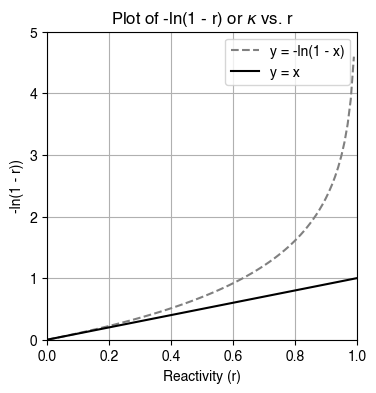

In [37]:
# plot -ln(1-r) vs. r for 0 -> 1
plt.figure(figsize=(4,4))
x_vals = np.linspace(0, 1, 100)
y_vals = -np.log(1 - x_vals)
y_linear = x_vals
plt.plot(x_vals, y_vals, color='gray', linestyle='--', label='y = -ln(1 - x)')
plt.plot(x_vals, y_linear, color='black', linestyle='-', label='y = x') 
plt.xlabel('Reactivity (r)')
plt.ylabel('-ln(1 - r))')
plt.title(r'Plot of -ln(1 - r) or $\kappa$ vs. r')
plt.xlim(0, 1)
plt.ylim(0, 5)
plt.grid(True)
plt.legend()
plt.show()

At endpoint, $r \approx k_{\text{obs}}$ -> good news for SHAPE, but not so for DMS. Raw rates = plateau point

### But $r$ does not scale linearly with time, so relative values may vary

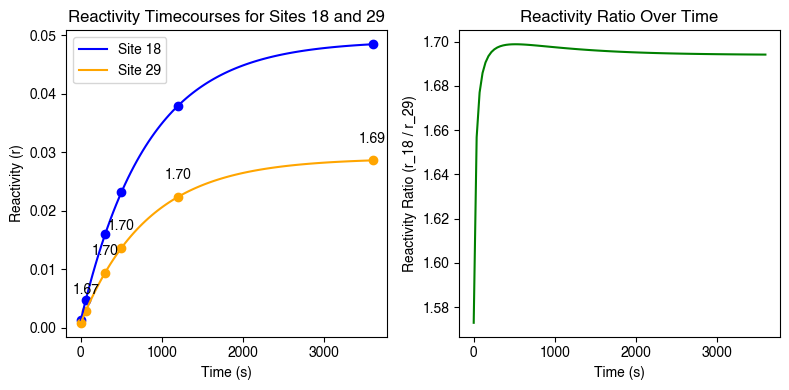

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First subplot - timecourses
ax1.plot(x_vals, y_vals_18, label='Site 18', color='blue')
ax1.plot(x_vals, y_vals_29, label='Site 29', color='orange')
ax1.scatter(x_vals_scatter, y_scatter_18, color='blue')
ax1.scatter(x_vals_scatter, y_scatter_29, color='orange')

# Annotate with ratio at each scatter time point
for i, (x, y18, y29) in enumerate(zip(x_vals_scatter, y_scatter_18, y_scatter_29)):
    if i > 0:  # Skip t=0 to avoid division by zero
        ratio = y18 / y29
        ax1.annotate(f'{ratio:.2f}', 
                    xy=(x, min(y18, y29)), 
                    xytext=(x, min(y18, y29) + 0.003),
                    ha='center', fontsize=10)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Reactivity (r)')
ax1.set_title('Reactivity Timecourses for Sites 18 and 29')
ax1.legend()
ax1.grid(False)

# Second subplot - ratios
ax2.plot(x_vals, ratios, label='Ratio of Site 18 to Site 29', color='green')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Reactivity Ratio (r_18 / r_29)')
ax2.set_title('Reactivity Ratio Over Time')
ax2.grid(False)

plt.tight_layout()
plt.show()
